# Quantum Fourier transform

In this tutorial, we will learn how to write and execute a quantum Fourier transform.

Warning: the bit ordering is not the same in input and output conventions. The relation between the input and output amplitudes is

$$\tilde{a}_{x}=\frac{1}{\sqrt{2^{n}}}\sum_{k=0}^{2^{n}}
\left(e^{\frac{2i\pi}{2^{n}}}\right)^{xk}a_{k}$$

with $|\psi_{\mathrm{in}}\rangle=\sum_{k=0}^{2^{n}-1}a_{k}|k\rangle$, $|\psi_{\mathrm{out}}\rangle
=\sum_{x=0}^{2^{n}-1}\tilde{a}_{x}|x\rangle$, and 

$|k\rangle=|b_{0}^{(k)},\dots b_{n-1}^{(k)}\rangle$ and $|x\rangle=
|b_{n-1}^{(x)},\dots,b_{0}^{(x)}\rangle$.



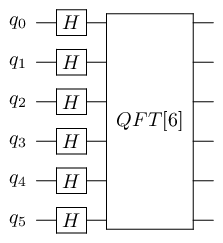

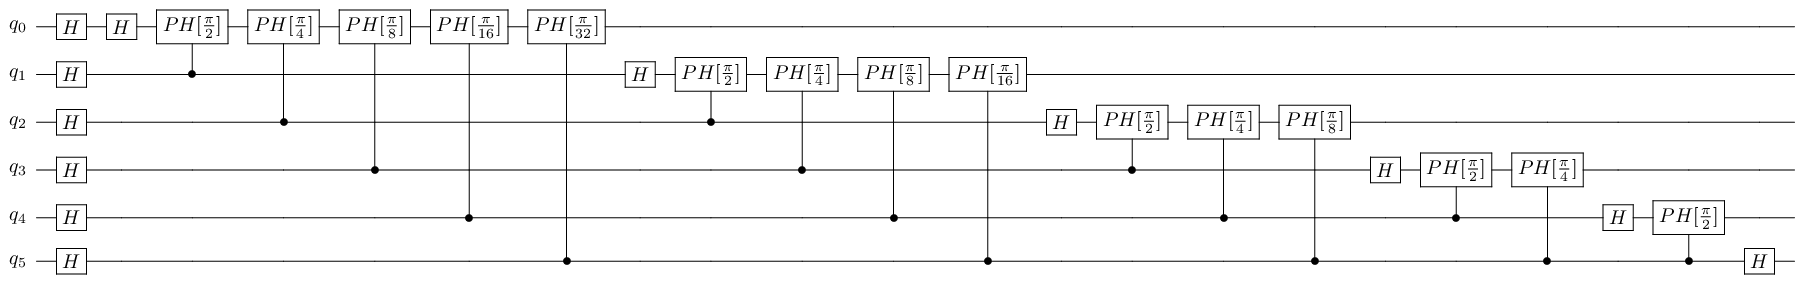

|000000> 0.999999999999998


In [6]:
from qat.lang.AQASM.qftarith import QFT
from qat.lang.AQASM import Program, H
from qat.qpus import get_default_qpu


nqbits = 6

prog = Program()
reg = prog.qalloc(nqbits)
for qb in range(nqbits):
    H(reg[qb])
prog.apply(QFT(nqbits), reg)

circ = prog.to_circ()

%qatdisplay circ

%qatdisplay circ --depth 2

qpu = get_default_qpu()
job = circ.to_job(nbshots=0)
res = qpu.submit(job)

for sample in res:
    print(sample.state, sample.probability)

## Our own implementation

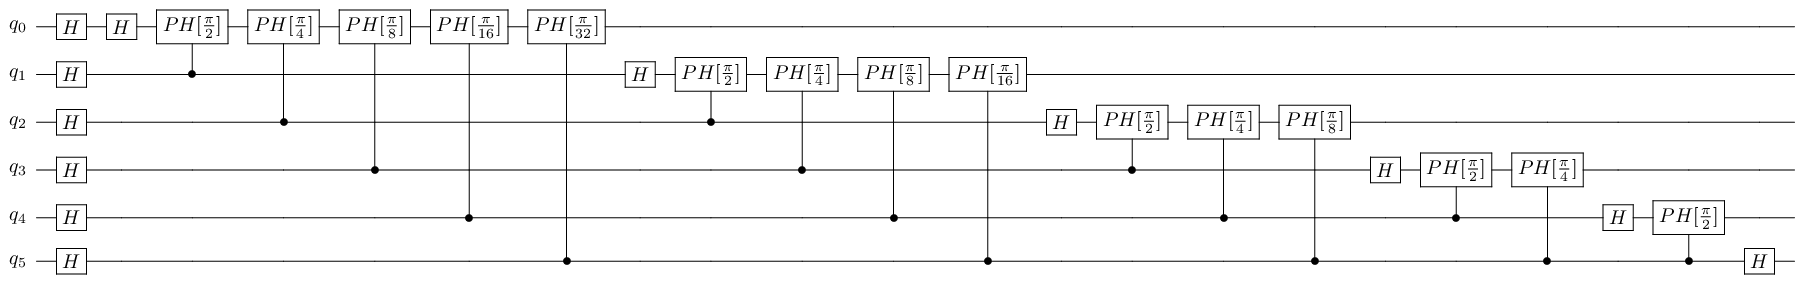

|000000> 0.999999999999998


In [7]:
import numpy as np
from qat.lang.AQASM import QRoutine, PH

def myQFT(nqbits):
    routine = QRoutine()
    for qb1 in range(nqbits):
        routine.apply(H, qb1)
        for qb2 in range(qb1 + 1, nqbits):
            angle = 2 * np.pi / 2**(qb2 - qb1 + 1)
            routine.apply(PH(angle).ctrl(), qb2, qb1)
    return routine

prog = Program()
reg = prog.qalloc(nqbits)
for qb in range(nqbits):
    H(reg[qb])
prog.apply(myQFT(nqbits), reg)

circ = prog.to_circ()

%qatdisplay circ

qpu = get_default_qpu()
job = circ.to_job(nbshots=0)
res = qpu.submit(job)

for sample in res:
    print(sample.state, sample.probability)

## FT of a signal ?